In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
data = pd.read_json(os.path.abspath('') + "/data2/sessions.jsonl", lines=True)
data = data[['session_id','timestamp','user_id','product_id','event_type','offered_discount','purchase_id']]

cleanup = {"event_type":{"BUY_PRODUCT":1, "VIEW_PRODUCT":-1}}
data = data.replace(cleanup)

In [2]:
data[0:100]

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-02-03 07:28:50,102.0,1283.0,-1,0,NaN
1,100002,2021-02-22 03:56:50,102.0,NaN,-1,5,NaN
2,100002,2021-02-22 03:57:09,102.0,1277.0,-1,5,NaN
3,100003,2021-02-15 07:55:33,102.0,1040.0,-1,0,NaN
4,100003,2021-02-15 07:57:14,102.0,1041.0,-1,0,NaN
...,...,...,...,...,...,...,...
95,100020,2021-03-25 21:45:19,102.0,1001.0,1,15,20005.0
96,100021,2021-03-20 01:11:57,NaN,1283.0,-1,0,NaN
97,100022,2021-03-26 02:18:22,102.0,1002.0,-1,0,NaN
98,100022,2021-03-26 02:22:08,102.0,1003.0,-1,0,NaN


<AxesSubplot:>

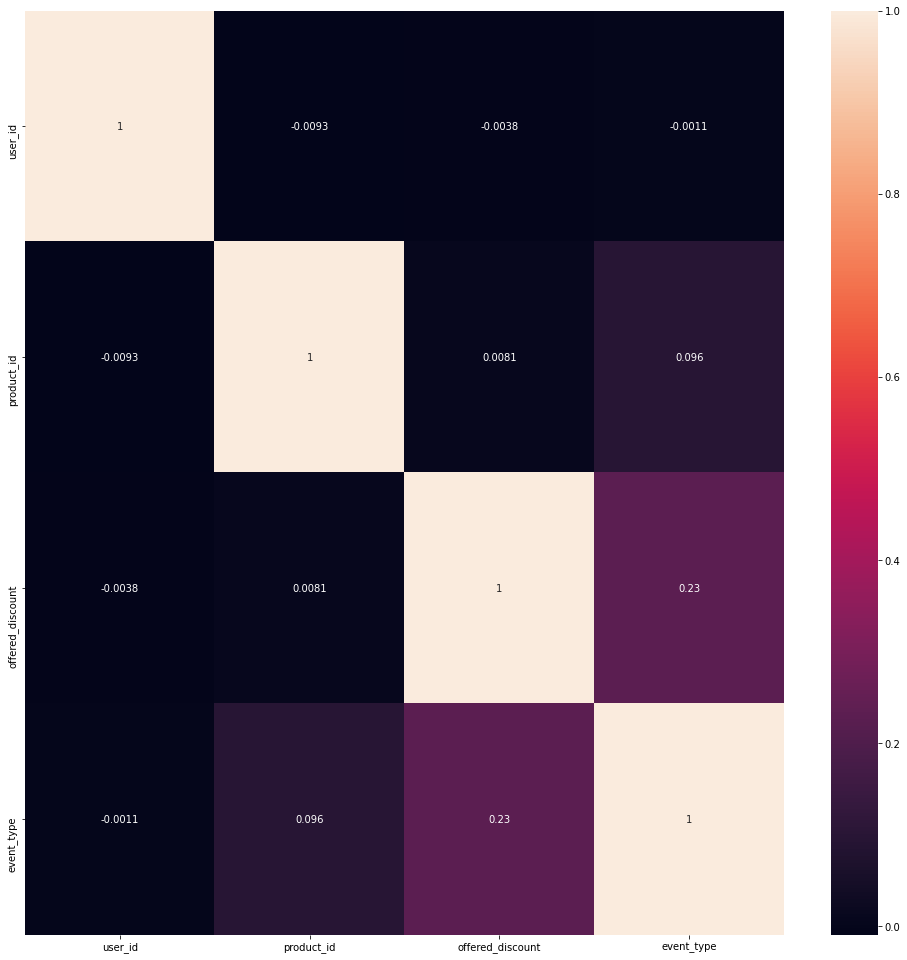

In [3]:
plt.figure(figsize=(17,17))
valuable_data = ['timestamp','user_id', 'product_id', 'offered_discount', 'event_type' ]
sns.heatmap(data[valuable_data].corr(),annot = True)

---

Wykres liczby zakupionych produktów zależnie od zaoferowanej zniżki

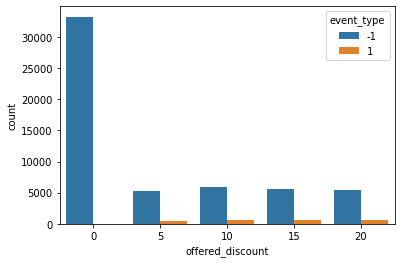

In [4]:
g = sns.countplot(x="offered_discount",hue="event_type",data=data)

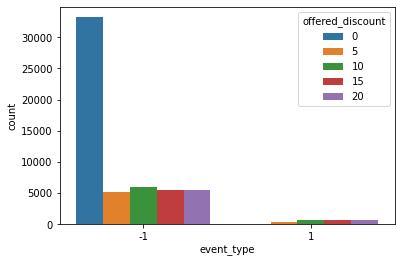

In [5]:
g2 = sns.countplot(x="event_type",hue="offered_discount",data=data)

---

Wykaz sesji zakończonych zakupem i tylko przeglądaniem (dla wszystkich użytkowników)

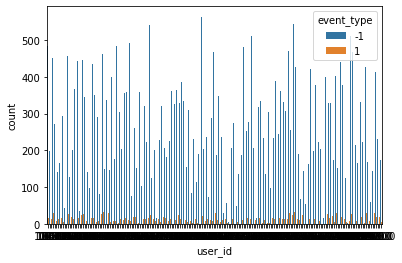

In [6]:
g3 = sns.countplot(x='user_id',hue='event_type',data=data)

---

Wykres liczby odwiedzin/zakupów w zależności od numeru ident. produktu

Możemy zauważyć, że w sklepie zakupione były tylko niektóre przedmioty, a większość była tylko przeglądana

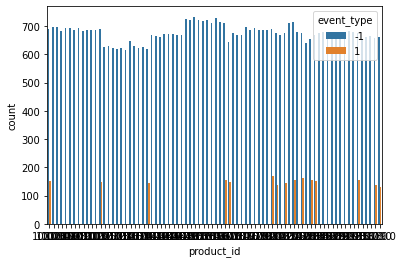

In [7]:
g4 = sns.countplot(x='product_id',hue='event_type',data=data)

---

Liczba zakupionych produktów w zależności od zaoferowanej zniżki

Można zauważyć, że nikt nie kupił produktu, jeśli nie dostał chociaż 5% zniżki

In [8]:
d1 = data[data.event_type == 1].groupby(['offered_discount']).count()['event_type']
d1

offered_discount
5     389
10    629
15    693
20    655
Name: event_type, dtype: int64

In [9]:
d2 = data.groupby(['offered_discount']).count()['event_type']
d2

offered_discount
0     33202
5      5650
10     6603
15     6252
20     6160
Name: event_type, dtype: int64

In [10]:
d3 = d1/d2
d3

offered_discount
0          NaN
5     0.068850
10    0.095260
15    0.110845
20    0.106331
Name: event_type, dtype: float64

Widzimy, że dla zniżek powyżej 5% ok 1/10 sesji, które miały taką zniżkę, zakończyła się zakupem

<AxesSubplot:title={'center':'buy to all'}, xlabel='offered_discount'>

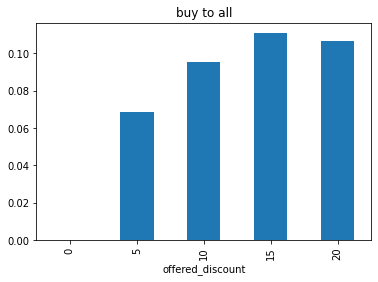

In [11]:
d3.plot(kind='bar',title='buy to all')

In [12]:
d4 = data[data.event_type == 1]
d4.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
24,100006,2021-03-16 13:39:32,102.0,1318.0,1,15,20001.0
48,100010,2021-02-21 00:01:22,102.0,1293.0,1,20,20002.0
69,100015,2021-02-05 19:34:13,102.0,1319.0,1,20,20003.0
93,100019,2021-02-10 12:40:54,102.0,1281.0,1,20,20004.0
95,100020,2021-03-25 21:45:19,102.0,1001.0,1,15,20005.0


---

Wykres liczby zakupów w zależności od zaoferowanej zniżki (dla wszystkich produktów)

<AxesSubplot:xlabel='product_id', ylabel='count'>

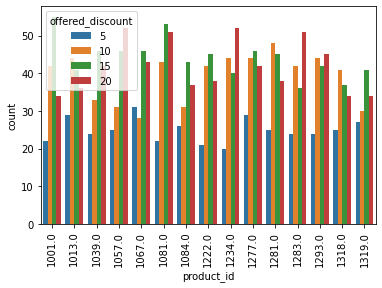

In [89]:
g_prod_disc = sns.countplot(x='product_id',hue='offered_discount',data=d4)
g_prod_disc.set_xticklabels(g_prod_disc.get_xticklabels(), rotation=90)
g_prod_disc

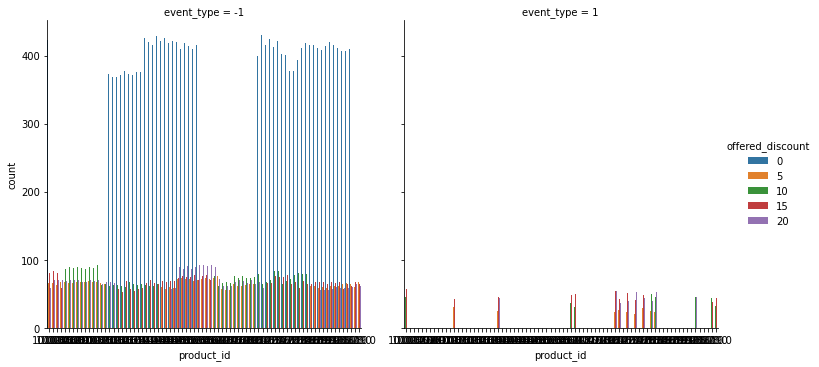

In [95]:
sns.catplot(data=data,x='product_id',hue='offered_discount',col='event_type',kind='count')

# Przetwarzanie danych

## Uzupełnianie brakujących danych

In [14]:
import numpy as np
clean_data = data
for i, d in clean_data.iterrows():
    if d.isnull().product_id and d.event_type == 1:
        clean_data.at[i,'product_id'] = data.at[i-1,'product_id']
    if d.isnull().product_id and clean_data.at[i+1,'event_type'] == 1:
        clean_data.at[i,'product_id'] = data.at[i+1,'product_id']
    if d.isnull().user_id:
        clean_data.at[i,'user_id'] = data[data.session_id == d.session_id]['user_id'].dropna().median()
clean_data = clean_data[valuable_data]


Tam, gdzie możemy, uzupełniamy brakujące user_id znając session_id. Zauważamy też, że w ramach jednej sesji każdy zakup zawsze poprzedzony jest obejrzeniem danego produktu. W ten sposób uzupełniamy potencjalne braki

In [15]:
clean_data

,timestamp,user_id,product_id,offered_discount,event_type
0,2021-02-03 07:28:50,102.0,1283.0,0,-1
1,2021-02-22 03:56:50,102.0,NaN,5,-1
2,2021-02-22 03:57:09,102.0,1277.0,5,-1
3,2021-02-15 07:55:33,102.0,1040.0,0,-1
4,2021-02-15 07:57:14,102.0,1041.0,0,-1
...,...,...,...,...,...
57862,2021-03-24 04:43:30,301.0,1034.0,0,-1
57863,2021-03-24 04:46:08,301.0,1036.0,0,-1
57864,2021-03-24 04:49:34,301.0,1037.0,0,-1
57865,2021-03-24 04:51:50,301.0,1038.0,0,-1


---

Sortujemy dane 

In [16]:
sorted_data = clean_data[valuable_data].dropna().sort_values(by = ['user_id','product_id','timestamp'])
sorted_data.head()

,timestamp,user_id,product_id,offered_discount,event_type
174,2021-03-05 05:26:32,102.0,1001.0,0,-1
94,2021-03-25 21:44:47,102.0,1001.0,15,-1
95,2021-03-25 21:45:19,102.0,1001.0,15,1
296,2021-01-14 15:57:42,102.0,1002.0,5,-1
497,2021-01-23 09:59:25,102.0,1002.0,10,-1


---

Dzielimy posortowane dane na części: 1 użytkownik - 1 produkt, posortowane po czasie sesji

In [17]:
dic = [x for _, x in sorted_data.groupby(["user_id", "product_id"])] 


---

Wcześniejsze części dzielimy na podzbiory "od zakupu do zakupu"

In [18]:
split_dic = []
for d in dic:
    last = 0
    for i in range(len(d)):
        if d.iloc[i].event_type == 1:
            split_dic.append(d[last:i+1])
            last = i+1
    if last < len(d):
        split_dic.append(d[last:len(d)])

---

Liczymy różnicę czasów w naszych podziałach, żeby wiedzieć, ile trwało od kiedy użytkownik wszedł na stronę produktu do momentu kiedy go kupił

In [19]:
for d in split_dic:
    t1 = d['timestamp'].diff()
    d.timestamp = t1

/home/tisek/.local/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
split_dic[3]

,timestamp,user_id,product_id,offered_discount,event_type
175,NaT,102.0,1004.0,0,-1
195,71 days 19:03:46,102.0,1004.0,0,-1
261,4 days 14:44:36,102.0,1004.0,0,-1
435,2 days 19:29:48,102.0,1004.0,15,-1


## Finalny zbiór danych

Na podstawie powyższych podziałów obliczamy liczbę wizyt, całkowity czas, maksymalną zaoferowaną zniżkę oraz czy klient finalnie kupił przedmiot

In [74]:
final_data = []
for d in split_dic:
    n_visits = len(d)
    d_time = d.sum().timestamp.total_seconds()
    max_disc = d.max().offered_discount
    curr_disc = d.tail(1).offered_discount.item()
    is_purchased = d.tail(1).event_type.item()
    final_data.append([d_time,n_visits,max_disc,curr_disc,is_purchased]) 

In [75]:
df = pd.DataFrame(final_data,columns=["d_time","n_visits","max_disc","curr_disc","is_purchased"])
df

,d_time,n_visits,max_disc,curr_disc,is_purchased
0,1786727.0,3,15,15,1
1,6085240.0,5,10,0,-1
2,6085181.0,5,10,0,-1
3,6844690.0,4,15,15,-1
4,6844813.0,4,15,15,-1
...,...,...,...,...,...
15376,4907844.0,2,15,15,-1
15377,4907795.0,2,15,15,-1
15378,4907724.0,2,15,15,-1
15379,0.0,1,0,0,-1


## Filtracja danych
Odrzucamy dane, które mają mają tylko jedno wejście z kilku powodów:  
1. Pierwsze wejście nie powinno być od razu nagradzane zniżką  
2. Niektóre rekordy mają zerowe czasy trwania, co mogłoby sugerować duże zdecydowanie, jednak jeśli produkt został zakupiony, zarejestrowane muszą zostać co najmniej 2 wejścia  
3. Mogą być wynikiem brakujących danych, których nie udało nam się odzyskać

In [76]:
df = df[df.n_visits > 1]
len(df)

12808

In [77]:
df.to_json(r'data2/final.json',orient="records",lines=True)

---

Mapa korelacji nowego zestawu danych

<AxesSubplot:>

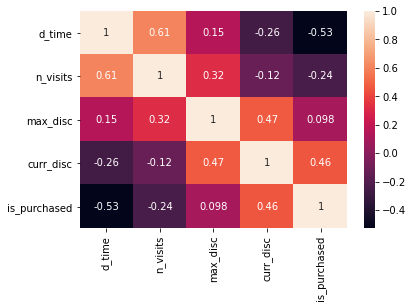

In [78]:
sns.heatmap(df.corr(),annot = True)

Widoczna jest silna korelacja pomiędzy zakupem i czasem oraz aktualną zniżką. Trochę gorzej, choć jednak wciąż znaczący wpływ ma liczba wizyt, zaś najgorzej wypada maksymalna zaoferowana do tej pory zniżka - zostawiamy ją jednak do dalszej analizy z powodu jej korelacji z obecną zniżką

---

Dodatkowa kolumna wizyt na minutę agregująca czas i wizyty oraz jednocześnie ograniczająca mocno wielkość danych wejściowych

In [79]:
visits_per_minute = df.n_visits / df.d_time * 60
df2 = df.copy(True)
df2.insert(2,"visits_per_minute",visits_per_minute,True) 

In [47]:
df2

,d_time,n_visits,visits_per_minute,max_disc,curr_disc,is_purchased
0,1786727.0,3,0.000101,10.000000,15,1
1,6085240.0,5,0.000049,3.000000,0,-1
2,6085181.0,5,0.000049,3.000000,0,-1
3,6844690.0,4,0.000035,3.750000,15,-1
4,6844813.0,4,0.000035,3.750000,15,-1
...,...,...,...,...,...,...
15375,665824.0,2,0.000180,0.000000,0,-1
15376,4907844.0,2,0.000024,12.500000,15,-1
15377,4907795.0,2,0.000024,12.500000,15,-1
15378,4907724.0,2,0.000024,12.500000,15,-1


In [64]:
df2[(df2.visits_per_minute > .1) & (df2.is_purchased != 1)]

,d_time,n_visits,visits_per_minute,max_disc,curr_disc,is_purchased
6031,759.0,2,0.158103,0.0,0,-1
6054,914.0,2,0.131291,0.0,0,-1


Jak widać ona również jest dość silnie skorelowana z zakupem 

<AxesSubplot:>

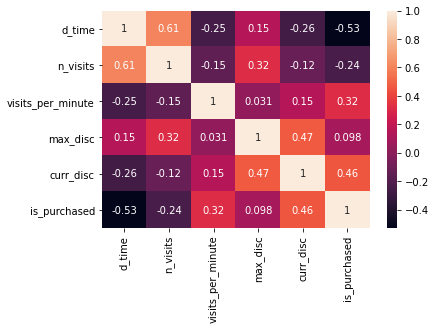

In [80]:
df2.to_json(r'data2/final_vpm.json',orient="records",lines=True)
sns.heatmap(df2.corr(),annot = True)

## Normalizacja danych
Normalizacja czasu metodą min-max

In [82]:
normal_t = df['d_time']
normalized_df = df.copy(True)
normalized_df.d_time = (normal_t-normal_t.min())/(normal_t.max()-normal_t.min())
df2.d_time = normalized_df.d_time

## Finalna postać próbki danych - wykresy

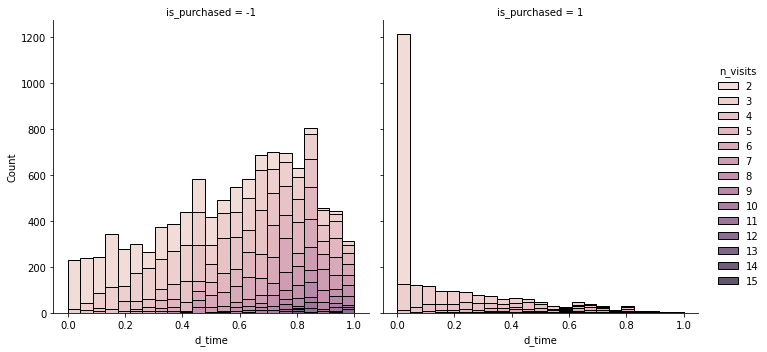

In [83]:
sns.displot(data=normalized_df,x='d_time',hue='n_visits',multiple='stack',col='is_purchased')

In [84]:
df2.to_json(r'data2/normal_vpm.json',orient="records",lines=True)
normalized_df.to_json(r'data2/normal_final.json',orient="records",lines=True)

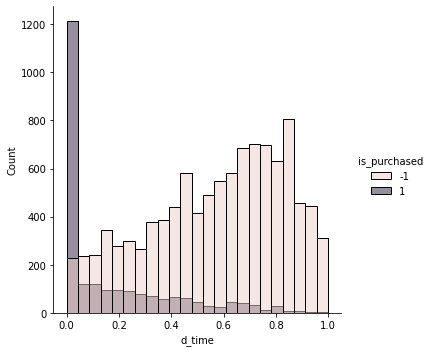

In [85]:
g_n1 = sns.displot(data = normalized_df,x='d_time',hue="is_purchased")

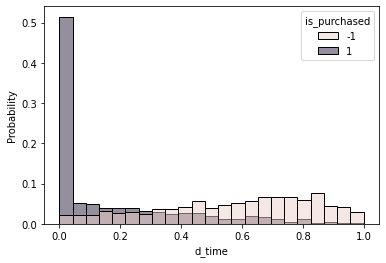

In [86]:
g_n2 = sns.histplot(data = normalized_df,x='d_time',hue="is_purchased",stat="probability",common_norm=False)

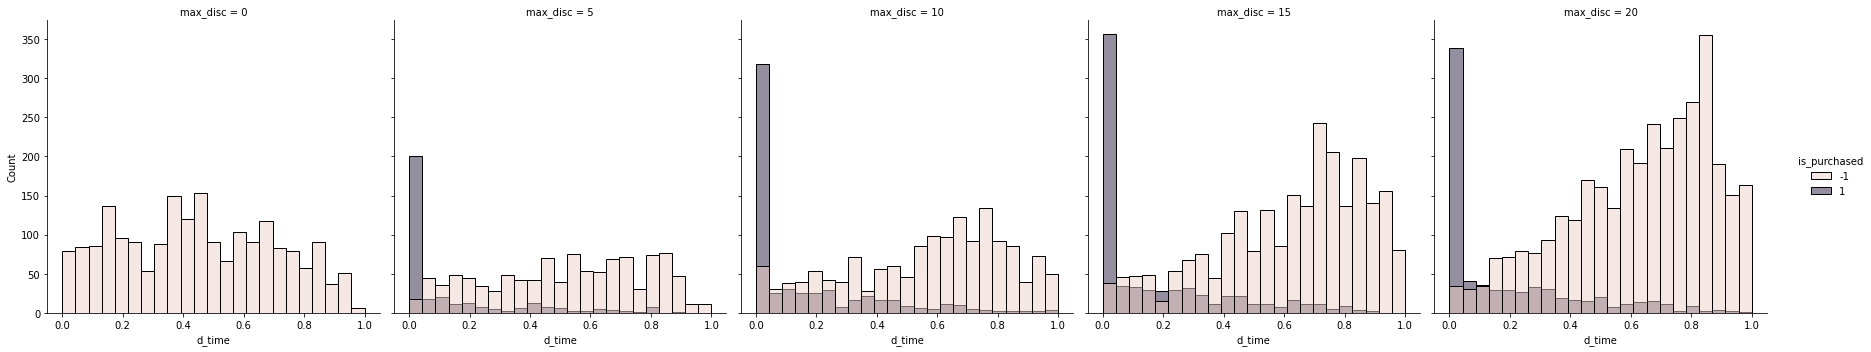

In [87]:
g_n3 = sns.displot(data = normalized_df,x='d_time',col="max_disc",hue="is_purchased")

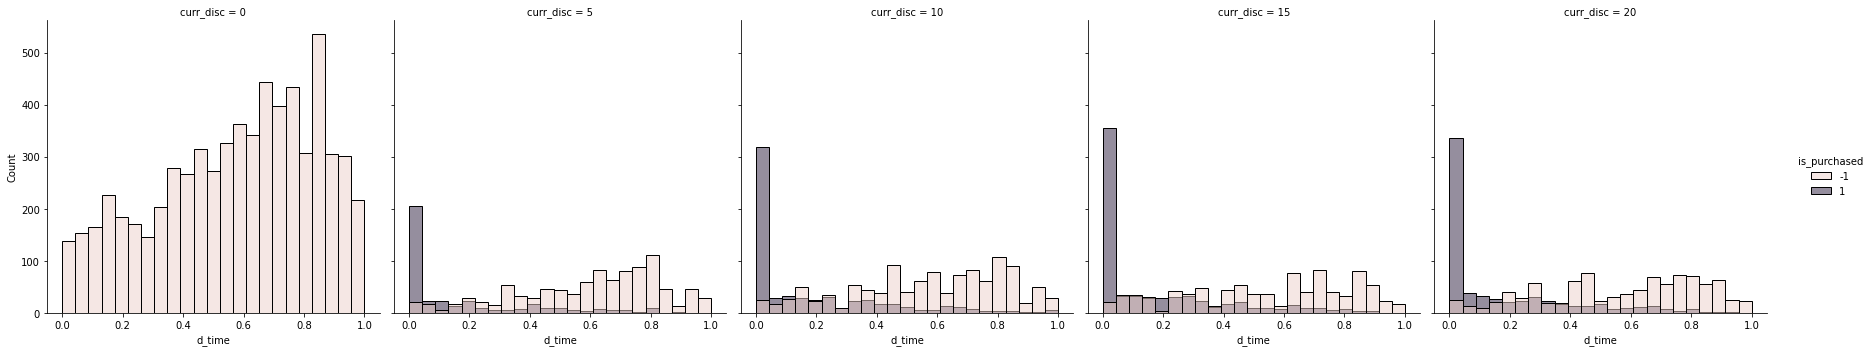

In [72]:
g_n4 = sns.displot(data = normalized_df,x='d_time',col="curr_disc",hue="is_purchased")

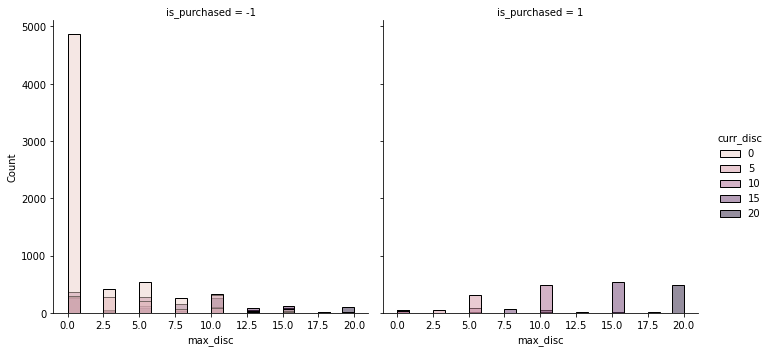

In [73]:
sns.displot(data=normalized_df,hue='curr_disc',x='max_disc',col='is_purchased')